In [5]:
# Taxonomy definitions: label, inclusion, and exclusion rules
TAXONOMY = [
    {
        "label": "Sale of Goods",
        "include": "Transfer of title or ownership in tangible, movable goods for a price; UCC-style language; delivery terms.",
        "exclude": "Any service-only arrangement; leases or rentals of personal property; intellectual-property licenses; financing terms; real estate transfers."
    },
    {
        "label": "Real Estate Contracts",
        "include": "Conveyance, lease, mortgage or transfer of interests in land or buildings; phrases like 'grant, bargain and sell', 'mortgage', 'leasehold premises'.",
        "exclude": "Sale or lease of personal property; service, construction, or management agreements not tied to land; IP licenses."
    },
    {
        "label": "Service Contracts",
        "include": "Provision of non-tangible services for compensation, such as consulting, repairs, maintenance, or software-as-a-service.",
        "exclude": "Sale or rental of goods; construction of real property; employment relationships; franchise or agency appointments; IP licensing."
    },
    {
        "label": "Construction Contracts",
        "include": "Design, build, renovate or modify real property or structures; includes architectural, engineering, and construction work orders.",
        "exclude": "Pure supply of materials without installation; service contracts unrelated to physical construction; employment-only agreements."
    },
    {
        "label": "Employment Contracts",
        "include": "Engagement of an individual as an employee, covering salary, benefits, duties, 'at-will' clauses, non-compete tied to employment.",
        "exclude": "Independent contractor or service-provider agreements; loan or financing contracts; agency appointments."
    },
    {
        "label": "Insurance Contracts",
        "include": "Promise to indemnify or pay upon occurrence of an insured event; includes 'policy', 'premium', 'coverage'.",
        "exclude": "Indemnity clauses embedded in broader contracts; guarantee or surety contracts; service-only agreements."
    },
    {
        "label": "Franchise Agreements",
        "include": "Grant of rights to operate a franchised business under franchisor’s system; mentions 'franchise fee', 'territory', 'royalties'.",
        "exclude": "Simple IP licenses; distributor or dealership agreements; agency or service-only contracts."
    },
    {
        "label": "Licensing Agreements",
        "include": "Permission to use intellectual property or intangible assets (patents, trademarks, software) for a fee or royalty.",
        "exclude": "Sale of goods; franchise arrangements; service contracts; leases."
    },
    {
        "label": "Loan Agreements",
        "include": "Lender-borrower relationship detailing principal, interest rate, and repayment schedule; mentions 'loan', 'principal', 'interest'.",
        "exclude": "Sale/lease of goods; investment or subscription agreements; guarantee contracts."
    },
    {
        "label": "Partnership Agreements",
        "include": "Creation of a partnership or joint venture; references 'partners', 'capital contributions', 'profit share'.",
        "exclude": "Service-only agreements; corporate bylaws; LLC operating agreements treated outside partnership scope."
    },
    {
        "label": "Lease Agreements",
        "include": "Grant of possession/use of property (real or personal) for a defined term in exchange for rent; mentions 'demised premises', 'lease term', 'rent'.",
        "exclude": "Sales contracts; maintenance agreements; subcontracts to perform work on leased property."
    },
    {
        "label": "Settlement Agreements",
        "include": "Resolution of disputes or claims; contains 'release', 'covenant not to sue', or dismissal terms.",
        "exclude": "Insurance policies; NDAs alone; indemnity clauses inside larger contracts."
    },
    {
        "label": "Indemnity Contracts",
        "include": "Promise to hold another harmless against losses or claims; phrases like 'indemnify and defend', 'hold harmless'.",
        "exclude": "Embedded indemnity clauses in other contracts; insurance or guarantee policies."
    },
    {
        "label": "Confidentiality (NDA) Agreements",
        "include": "Obligations not to disclose certain non-public information; mentions 'confidential information', 'purpose', 'return of materials'.",
        "exclude": "Contracts primarily for employment, licensing, or sale of goods even if NDA sections present."
    },
    {
        "label": "Guarantee Contracts",
        "include": "Third party's promise to fulfill another's obligation upon default; contains 'guarantor', 'guarantee', 'in case of default'.",
        "exclude": "Primary loan agreements; indemnity contracts; insurance policies."
    },
    {
        "label": "Agency Agreements",
        "include": "Appointment of an agent to act on behalf of a principal; uses 'agent', 'authority', 'fiduciary', 'commission'.",
        "exclude": "Employment contracts; distributor/dealership agreements; partnership agreements."
    }
]


In [107]:
import os
import json
import openai
import pandas as pd
import textwrap
from IPython.display import display, HTML
from google.colab import userdata
import re

openai.api_key = userdata.get('OPENAI_2')

In [95]:
# Load JSON files into a df
def load_contracts(json_paths):
    rows = []
    for path in json_paths:
        filename = os.path.splitext(os.path.basename(path))[0]
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for item in data:
                item['id'] = filename + "_" + str(item['id'])
            rows.extend(data)
    return pd.DataFrame(rows)

# Helper to build the taxonomy prompt string
def build_taxonomy_prompt(taxonomy):
    lines = []
    for entry in taxonomy:
        lines.append(f"{entry['label']}:\n  Include: {entry['include']}\n  Exclude: {entry['exclude']}\n")
    return "\n".join(lines)

TAXONOMY_PROMPT = build_taxonomy_prompt(TAXONOMY)

In [123]:
# Helper for parsing response
def _extract_json(content: str) -> str:
    # More flexible regex to capture JSON array, even if it is not enclosed in code fences.
    pattern = re.compile(r"```(?:json)?\s*(\[\s*[\s\S]*?\])\s*```", re.IGNORECASE)
    m = pattern.search(content)
    return m.group(1) if m else content

# Seed labeling function
def label_seed_documents(
    df: pd.DataFrame,
    text_col: str = "text",
    id_col: str = "id",
    seed_size: int = 200,
    batch_size: int = 20,
    max_char: int = 2000,
    specific_ids: list[str] = None
) -> pd.DataFrame:
    """
    Samples `seed_size` docs from df, batches them, and uses chatgpt to label each
    document with one of the TAXONOMY labels. Returns a DataFrame with:
    [id, snippet, predicted_label, confidence, rationale].
    """
    # Sample
    if specific_ids is not None:
        seed_df = df[df[id_col].isin(specific_ids)].reset_index(drop=True)
    else:
        seed_df = df.sample(n=seed_size).reset_index(drop=True)

    results = []

    # Process in batches
    for i in range(0, seed_size, batch_size):
        batch = seed_df.iloc[i : i + batch_size]
        items = []
        snippet_map = {}
        for _, row in batch.iterrows():
            sid = str(row[id_col])       # normalize to string
            snippet = textwrap.shorten(row[text_col], width=max_char, placeholder="…")
            items.append({"id": sid, "text": snippet})
            snippet_map[sid] = snippet

        # Build prompt
        system_msg = {
            "role": "system",
            "content": (
                "You are a legal contract classification assistant. "
                "Assign each contract to exactly one of the 16 provided types."
            )
        }
        user_msg = {
            "role": "user",
            "content": (
                f"Here are the definitions for each contract type:\n\n"
                f"{TAXONOMY_PROMPT}\n\n"
                f"Classify the following contracts.  Respond with a JSON array of objects:\n"
                f"[{{\"id\": str, \"predicted_label\": str, \"confidence\": float (0–1), \"rationale\": str}}]\n\n"
                f"Contracts:\n" + "\n".join(
                    f"ID: {it['id']}\nText: {it['text']}\n" for it in items
                )
            )
        }

        # Call OpenAI
        response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[system_msg, user_msg],
        temperature=0.0,
        max_tokens=2048
        )

        # Parse JSON
        raw = response.choices[0].message.content.strip()
        payload = _extract_json(raw)

        try:
            parsed = json.loads(payload)
        except json.JSONDecodeError:
            raise ValueError(f"Could not parse JSON. Raw:\n{raw}\n\nExtracted:\n{payload}")


        # Collect
        for obj in parsed:
            sid = str(obj.get("id", ""))
            snippet = snippet_map.get(sid, "")
            if snippet == "":
                print(f"Warning: ID {sid} not found in this batch, leaving snippet blank.")
            results.append({
                "id": sid,
                "snippet": snippet,
                "predicted_label": obj.get("predicted_label",""),
                "confidence": obj.get("confidence", None),
                "rationale": obj.get("rationale","")
            })

    return pd.DataFrame(results)


In [109]:
df = load_contracts([
    "cuad.json",
    "contractnli.json"
])

In [91]:
seed_labels = label_seed_documents(df, seed_size=200, batch_size=10)

In [108]:
seed_labels

,id,snippet,predicted_label,confidence,rationale
0,contractnli_450,NON-DISCLOSURE AGREEMENT FFI Contact Name: ___...,Confidentiality (NDA) Agreements,0.95,The contract is a Non-Disclosure Agreement (ND...
1,cuad_289,Exhibit 10.12.1 Confidential Execution Version...,Partnership Agreements,0.90,"The contract is a Joint Venture Agreement, whi..."
2,cuad_207,Contract No.: DDCX S DG KC 201812130044 Exhibi...,Service Contracts,0.85,The contract outlines a collaboration agreemen...
3,contractnli_388,MUTUAL NON-DISCLOSURE AGREEMENT THIS AGREEMENT...,Confidentiality (NDA) Agreements,0.95,This is a Mutual Non-Disclosure Agreement that...
4,contractnli_89,Data Use And Non-Disclosure Agreement Between ...,Confidentiality (NDA) Agreements,0.95,The contract is a Data Use and Non-Disclosure ...
...,...,...,...,...,...
195,cuad_272,Exhibit 10.27 e-business Hosting Agreement bet...,Service Contracts,0.80,The e-business Hosting Agreement involves the ...
196,contractnli_544,Exhibit (d)(6) NON-DISCLOSURE AGREEMENT This n...,Confidentiality (NDA) Agreements,0.95,This is a Non-Disclosure Agreement that protec...
197,contractnli_397,NON-COMPETITION AGREEMENT THIS NON-COMPETITION...,Employment Contracts,0.85,The Non-Competition Agreement is tied to an em...
198,contractnli_45,"NON-DISCLOSURE AGREEMENT This Agreement, effec...",Confidentiality (NDA) Agreements,0.95,This is a Non-Disclosure Agreement focused on ...


In [114]:
full_labels = label_seed_documents(df, seed_size=1117, batch_size=10)

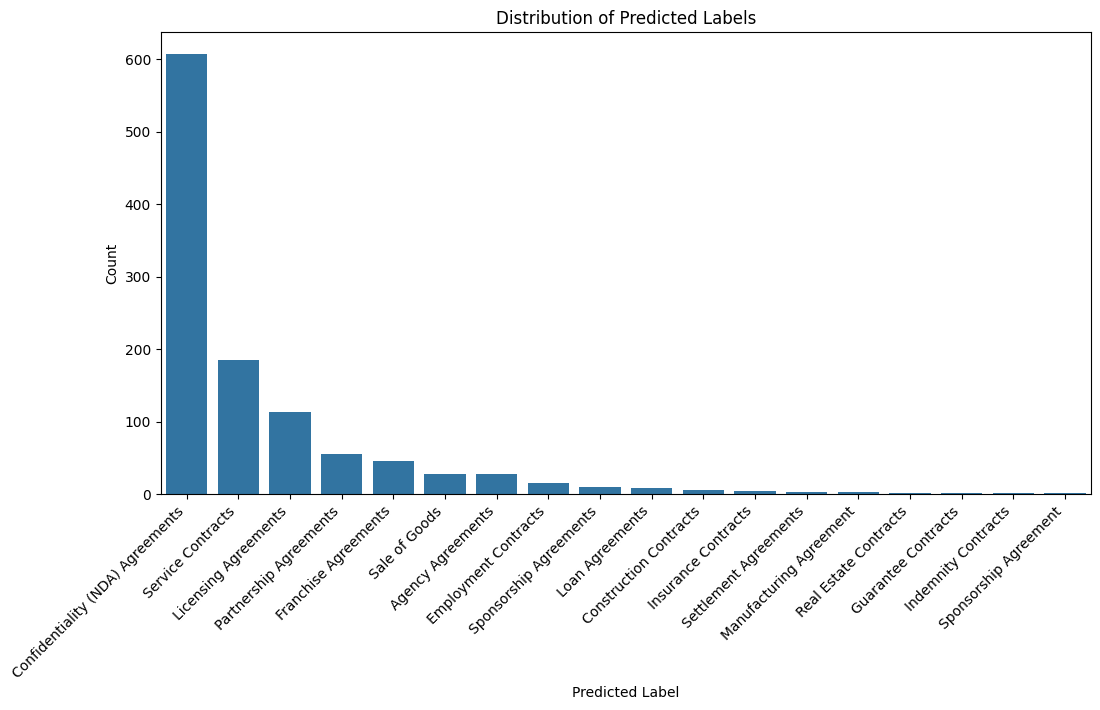

,Predicted Label,Count
0,Confidentiality (NDA) Agreements,607
1,Service Contracts,185
2,Licensing Agreements,113
3,Partnership Agreements,55
4,Franchise Agreements,46
5,Sale of Goods,28
6,Agency Agreements,28
7,Employment Contracts,16
8,Sponsorship Agreements,10
9,Loan Agreements,8


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(x='predicted_label', data=full_labels, order=full_labels['predicted_label'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()

label_counts = full_labels['predicted_label'].value_counts().reset_index()
label_counts.columns = ['Predicted Label', 'Count']
display(label_counts)


In [143]:
full_labels.to_csv('full_labels.csv', index=False)